## Importing Libraries

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns

In [119]:
import csv
# import re
# import nltk
# from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.colors as mcolors

## Reading Dataset

In [120]:
dataset = pd.read_csv('preelection.csv')

## Understanding the Data

In [121]:
dataset.head()

,Tweets,Date,Username,Number of Retweets,Number of Likes
0,A year ago! Any progress from the winning cand...,5/5/2022,youth4climatePH,1.0,1
1,"Bongbong Marcos, Sara Duterte express deepest ...",5/4/2022,BayanihanToday,22.0,166
2,I decide I only vote for\r\nBBM❤️ SARA DUTERTE...,5/7/2022,pjmscheesecake_,1.0,1
3,Mr. Bbm and Ms. Sara Duterte are obviously wil...,5/4/2022,Wonderwomanneph,0.0,0
4,THE CROWD IS INSANE. BBM YOULL FOREVER BE INSA...,5/7/2022,queen_pinksss,601.0,2745


In [122]:
dataset.shape

(3407, 5)

In [123]:
dataset.dtypes

Tweets                 object
Date                   object
Username               object
Number of Retweets    float64
Number of Likes        object
dtype: object

In [124]:
dataset.describe()

,Number of Retweets
count,3405.000000
mean,22.797063
std,178.719840
min,0.000000
25%,0.000000
50%,1.000000
75%,11.000000
max,7463.000000


In [125]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3407 entries, 0 to 3406
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tweets              3407 non-null   object 
 1   Date                3407 non-null   object 
 2   Username            3407 non-null   object 
 3   Number of Retweets  3405 non-null   float64
 4   Number of Likes     3404 non-null   object 
dtypes: float64(1), object(4)
memory usage: 133.2+ KB


In [126]:
dataset.isna().sum()

Tweets                0
Date                  0
Username              0
Number of Retweets    2
Number of Likes       3
dtype: int64

## Data Cleaning

In [127]:
#Raw Dataset
dataset

,Tweets,Date,Username,Number of Retweets,Number of Likes
0,A year ago! Any progress from the winning cand...,5/5/2022,youth4climatePH,1.0,1
1,"Bongbong Marcos, Sara Duterte express deepest ...",5/4/2022,BayanihanToday,22.0,166
2,I decide I only vote for\r\nBBM❤️ SARA DUTERTE...,5/7/2022,pjmscheesecake_,1.0,1
3,Mr. Bbm and Ms. Sara Duterte are obviously wil...,5/4/2022,Wonderwomanneph,0.0,0
4,THE CROWD IS INSANE. BBM YOULL FOREVER BE INSA...,5/7/2022,queen_pinksss,601.0,2745
...,...,...,...,...,...
3402,Heartbreaking that independent pollsters have ...,5/4/2022,jonathan_c_ong\r\n,12.0,50
3403,Dropped off my daughter this morning then proc...,4/29/2022,jjjohaira\r\n,0.0,9
3404,"Hindi lang yon. Yung kasalanan ng dilawan, kas...",5/2/2022,pilipinoako2022\r,0.0,0
3405,Vote \r\n@rowena_guanzon\r\n and \r\n@P3PWD_PL...,4/29/2022,jaereports\r\n,1.0,8


In [128]:
#1 Drop unnecessary columns

dataset.drop(['Date','Username','Number of Retweets','Number of Likes'], axis=1, inplace=True)
dataset

,Tweets
0,A year ago! Any progress from the winning cand...
1,"Bongbong Marcos, Sara Duterte express deepest ..."
2,I decide I only vote for\r\nBBM❤️ SARA DUTERTE...
3,Mr. Bbm and Ms. Sara Duterte are obviously wil...
4,THE CROWD IS INSANE. BBM YOULL FOREVER BE INSA...
...,...
3402,Heartbreaking that independent pollsters have ...
3403,Dropped off my daughter this morning then proc...
3404,"Hindi lang yon. Yung kasalanan ng dilawan, kas..."
3405,Vote \r\n@rowena_guanzon\r\n and \r\n@P3PWD_PL...


In [129]:
#Get the exact duplicate tweets in the dataframe
print("Duplicate Tweets:", len(dataset['Tweets'])-len(dataset['Tweets'].drop_duplicates()))

Duplicate Tweets: 499


In [130]:
# 2 Remove Exact Duplicate Tweets
# Drop the last duplicate and keep the first one
dataset.drop_duplicates(subset='Tweets', keep="first", inplace=True)
dataset = dataset.reset_index()

In [131]:
dataset.drop(['index'], axis=1, inplace=True)
dataset

,Tweets
0,A year ago! Any progress from the winning cand...
1,"Bongbong Marcos, Sara Duterte express deepest ..."
2,I decide I only vote for\r\nBBM❤️ SARA DUTERTE...
3,Mr. Bbm and Ms. Sara Duterte are obviously wil...
4,THE CROWD IS INSANE. BBM YOULL FOREVER BE INSA...
...,...
2903,“Aksyon Agad” is also the tagline of QC distri...
2904,My message to foreign nations. Don't you dare ...
2905,"Hindi lang yon. Yung kasalanan ng dilawan, kas..."
2906,Vote \r\n@rowena_guanzon\r\n and \r\n@P3PWD_PL...


In [132]:
# Get the percentage of emojis in the dataset
def calculate_percentage_of_emojis(text):
    emoji_pattern = re.compile(r'\p{Emoji}')
    
    emojis = emoji_pattern.findall(text)
    
    # Calculate the percentage of Unicode emojis
    total_chars = len(text)
    if total_chars > 0:
        percentage = (len(emojis) / total_chars) * 100
    else:
        percentage = 0
    return percentage

overall_percentage_of_emojis = dataset['Tweets'].apply(calculate_percentage_of_emojis).mean()

print(f"Overall Percentage of Emojis in the Dataset: {overall_percentage_of_emojis:.2f}%")

Overall Percentage of Emojis in the Dataset: 6.67%


In [133]:
# 3 Transform Emojis to Text
def transform_emojis(text):
    text = emoji.demojize(text, delimiters=(" ", " "))
    return text

dataset['Tweets'] = dataset['Tweets'].apply(transform_emojis)
dataset

,Tweets
0,A year ago! Any progress from the winning cand...
1,"Bongbong Marcos, Sara Duterte express deepest ..."
2,I decide I only vote for\r\nBBM red_heart SAR...
3,Mr. Bbm and Ms. Sara Duterte are obviously wil...
4,THE CROWD IS INSANE. BBM YOULL FOREVER BE INSA...
...,...
2903,“Aksyon Agad” is also the tagline of QC distri...
2904,My message to foreign nations. Don't you dare ...
2905,"Hindi lang yon. Yung kasalanan ng dilawan, kas..."
2906,Vote \r\n@rowena_guanzon\r\n and \r\n@P3PWD_PL...


In [134]:
# 4 Replace "#" with the word "hashtag" in the "Tweets" column
dataset['Tweets'] = dataset['Tweets'].str.replace("#", "hashtag")
dataset

,Tweets
0,A year ago! Any progress from the winning cand...
1,"Bongbong Marcos, Sara Duterte express deepest ..."
2,I decide I only vote for\r\nBBM red_heart SAR...
3,Mr. Bbm and Ms. Sara Duterte are obviously wil...
4,THE CROWD IS INSANE. BBM YOULL FOREVER BE INSA...
...,...
2903,“Aksyon Agad” is also the tagline of QC distri...
2904,My message to foreign nations. Don't you dare ...
2905,"Hindi lang yon. Yung kasalanan ng dilawan, kas..."
2906,Vote \r\n@rowena_guanzon\r\n and \r\n@P3PWD_PL...


In [135]:
# 5 Remove non-alphanumeric characters, spaces & links
def clean_text(text):
    text = text.replace('?', ' ').replace('!', ' ') # Remove question marks, exclamation points
    text = ' '.join([word for word in text.split() if not word.startswith('@')]) # Remove mention tags
    text = text.replace('\n', ' ') # Remove newline characters

    # Remove all non-alphanumeric characters except hashtags, underscores, and spaces
    text = re.sub(r'[^a-zA-Z0-9_#\s]', '', text)

    # Remove links (http/s and youtube)
    text = ' '.join([word for word in text.split() if not word.startswith(('http://', 'https://', 'youtube', 'youtu be'))]) 
    text = text.replace('...', ' ') # Remove ellipses
    text = ' '.join(text.split()) # Replace multiple spaces with a single space
    text = text.strip() # Remove leading/trailing spaces
    return text

dataset['Tweets'] = dataset['Tweets'].apply(clean_text)
print(dataset)

                                                 Tweets
0     A year ago Any progress from the winning candi...
1     Bongbong Marcos Sara Duterte express deepest g...
2     I decide I only vote for BBM red_heart SARA DU...
3     Mr Bbm and Ms Sara Duterte are obviously will ...
4     THE CROWD IS INSANE BBM YOULL FOREVER BE INSAN...
...                                                 ...
2903  Aksyon Agad is also the tagline of QC district...
2904  My message to foreign nations Dont you dare to...
2905  Hindi lang yon Yung kasalanan ng dilawan kasal...
2906  Vote and for Congress a representative and par...
2907  This elections never forget those who voted ag...

[2908 rows x 1 columns]


In [136]:
# 6 Tokenization
# nltk.download('punkt')

dataset['Tokenized_Tweets'] = dataset['Tweets'].apply(lambda x: word_tokenize(x))

dataset['Tokenized_Tweets']

0       [A, year, ago, Any, progress, from, the, winni...
1       [Bongbong, Marcos, Sara, Duterte, express, dee...
2       [I, decide, I, only, vote, for, BBM, red_heart...
3       [Mr, Bbm, and, Ms, Sara, Duterte, are, obvious...
4       [THE, CROWD, IS, INSANE, BBM, YOULL, FOREVER, ...
                              ...                        
2903    [Aksyon, Agad, is, also, the, tagline, of, QC,...
2904    [My, message, to, foreign, nations, Dont, you,...
2905    [Hindi, lang, yon, Yung, kasalanan, ng, dilawa...
2906    [Vote, and, for, Congress, a, representative, ...
2907    [This, elections, never, forget, those, who, v...
Name: Tokenized_Tweets, Length: 2908, dtype: object

In [137]:
# 7 Case Transformation
# Function to transform tokenized tweets to lowercase
def lowercase_tokens(tokens):
    return [token.lower() for token in tokens]

dataset['Tokenized_Tweets'] = dataset['Tokenized_Tweets'].apply(lambda x: lowercase_tokens(x))
print(dataset['Tokenized_Tweets'])

0       [a, year, ago, any, progress, from, the, winni...
1       [bongbong, marcos, sara, duterte, express, dee...
2       [i, decide, i, only, vote, for, bbm, red_heart...
3       [mr, bbm, and, ms, sara, duterte, are, obvious...
4       [the, crowd, is, insane, bbm, youll, forever, ...
                              ...                        
2903    [aksyon, agad, is, also, the, tagline, of, qc,...
2904    [my, message, to, foreign, nations, dont, you,...
2905    [hindi, lang, yon, yung, kasalanan, ng, dilawa...
2906    [vote, and, for, congress, a, representative, ...
2907    [this, elections, never, forget, those, who, v...
Name: Tokenized_Tweets, Length: 2908, dtype: object


In [138]:
# Create Abbreviation Dictionary
abbreviation_dict = {}
abbreviation = pd.read_csv('abbreviation_updated.csv')
with open('abbreviation_updated.csv', mode='r') as inp:
  reader = csv.reader(inp)
  abbreviation_dict = {rows[0]:rows[1] for rows in reader}
abbreviation_dict

{'88m': 'bbm',
 'accling': 'queer',
 'ad': 'advertisement',
 'agri': 'agricultural',
 'amp ': 'ang puta',
 'ampalaya': 'bitter',
 'anniv': 'anniversary',
 'app': 'application',
 'ar': 'augmented reality',
 'atty': 'attorney',
 'ave': 'avenue',
 'b4': 'before',
 'babym': 'bbm',
 'bcoz': 'because',
 'bcs': 'because',
 'bec': 'because',
 'beh': 'best friend',
 'bei': 'board of election inspector',
 'bes': 'best friend',
 'besh': 'best friend',
 'beshie': 'best friend',
 'beybiem': 'bbm',
 'bgy': 'barangay',
 'bishies': 'best friend',
 'blengbong': 'bongbong',
 'bp': 'bise presidente',
 'brgy': 'barangay',
 'brgys': 'barangays',
 'bs': 'bull shit',
 'bugok': 'stupid',
 'bull': 'ridiculous',
 'c/o': 'credit to the owner',
 'camsur': 'camarines sur',
 'chariz': 'joke',
 'charot': 'joke',
 'charots': 'joke',
 'clav': 'commitee on local absentee voting',
 'cmd': 'christian muslim democrats',
 'coc': 'certificate of candidacy',
 'cocs': 'certificate of candidacy',
 'coe': 'commission on electio

In [139]:
#Adding underscores for abbreviation definitions that have more than one word

abbreviation_dict = {key:value.replace(' ','_')for key, value in abbreviation_dict.items()}
abbreviation_dict

{'88m': 'bbm',
 'accling': 'queer',
 'ad': 'advertisement',
 'agri': 'agricultural',
 'amp ': 'ang_puta',
 'ampalaya': 'bitter',
 'anniv': 'anniversary',
 'app': 'application',
 'ar': 'augmented_reality',
 'atty': 'attorney',
 'ave': 'avenue',
 'b4': 'before',
 'babym': 'bbm',
 'bcoz': 'because',
 'bcs': 'because',
 'bec': 'because',
 'beh': 'best_friend',
 'bei': 'board_of_election_inspector',
 'bes': 'best_friend',
 'besh': 'best_friend',
 'beshie': 'best_friend',
 'beybiem': 'bbm',
 'bgy': 'barangay',
 'bishies': 'best_friend',
 'blengbong': 'bongbong',
 'bp': 'bise_presidente',
 'brgy': 'barangay',
 'brgys': 'barangays',
 'bs': 'bull_shit',
 'bugok': 'stupid',
 'bull': 'ridiculous',
 'c/o': 'credit_to_the_owner',
 'camsur': 'camarines_sur',
 'chariz': 'joke',
 'charot': 'joke',
 'charots': 'joke',
 'clav': 'commitee_on_local_absentee_voting',
 'cmd': 'christian_muslim_democrats',
 'coc': 'certificate_of_candidacy',
 'cocs': 'certificate_of_candidacy',
 'coe': 'commission_on_electio

In [140]:
# 8 Abbreviation Transformation
def transform_abbreviations_within_tokens(tokens, abbreviation_dict):
    transformed_tokens = []
    
    for token in tokens:
        words = token.split()
        transformed_words = []
        
        for word in words:
            if word in abbreviation_dict:
                transformed_words.append(abbreviation_dict[word])
            else:
                transformed_words.append(word)
        
        transformed_token = ' '.join(transformed_words)
        transformed_tokens.append(transformed_token)
    
    return transformed_tokens

dataset['Tokenized_Tweets'] = dataset['Tokenized_Tweets'].apply(lambda x: transform_abbreviations_within_tokens(x, abbreviation_dict))
print(dataset['Tokenized_Tweets'])

0       [a, year, ago, any, progress, from, the, winni...
1       [bongbong, marcos, sara, duterte, express, dee...
2       [i, decide, i, only, vote, for, bbm, red_heart...
3       [mr, bbm, and, ms, sara, duterte, are, obvious...
4       [the, crowd, is, insane, bbm, youll, forever, ...
                              ...                        
2903    [aksyon, agad, is, also, the, tagline, of, qc,...
2904    [my, message, to, foreign, nations, dont, you,...
2905    [hindi, lang, yon, yung, kasalanan, ng, dilawa...
2906    [vote, and, for, congress, a, representative, ...
2907    [this, elections, never, forget, those, who, v...
Name: Tokenized_Tweets, Length: 2908, dtype: object


In [141]:
# 9 Misspelled Words Transformation
from chardet import detect
from spellchecker import SpellChecker
import nltk
from nltk.tokenize import word_tokenize

spell_checker_en = SpellChecker()

tagalog_word_list = []
with open('tl_PH.aff', 'r', encoding='utf-8') as word_list_file:
    tagalog_word_list = [line.strip() for line in word_list_file]


def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown" 
def correct_words(tokens):
    language = detect_language(' '.join(tokens))
    
    corrected_tokens = [
        spell_checker_en.correction(word) if language == 'en' else
        word.lower() if language == 'tl' and word.lower() in tagalog_word_list else
        word
        for word in tokens
    ]

    return corrected_tokens

dataset['Corrected_Words'] = dataset['Tokenized_Tweets'].apply(correct_words)
print(dataset['Corrected_Words'])

0       [a, year, ago, any, progress, from, the, winni...
1       [bongbong, marcos, sara, duterte, express, dee...
2       [i, decide, i, only, vote, for, bbm, red_heart...
3       [mr, bbm, and, ms, sara, duterte, are, obvious...
4       [the, crowd, is, insane, bbm, youll, forever, ...
                              ...                        
2903    [aksyon, agad, is, also, the, tagline, of, qc,...
2904    [my, message, to, foreign, nations, dont, you,...
2905    [hindi, lang, yon, yung, kasalanan, ng, dilawa...
2906    [vote, and, for, congress, a, representative, ...
2907    [this, elections, never, forget, those, who, v...
Name: Corrected_Words, Length: 2908, dtype: object


In [142]:
# Store Stopwords
tag_stopwords = (['akin', 'aking', 'ako', 'alin', 'am', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'ba', 'bababa', 'bago', 'bakit', 'bawat', 'bilang', 'eh', 'dahil', 'dalawa', 'dapat','daw', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa', 'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw', 'ilagay', 'ilalim', 'ilan','ilang', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan', 'kailanman', 'kami', 'kanila', 'kanilang', 'kanino','kaniyang', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan', 'katulad', 'kasi', 'kay', 'kaya','kayo', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang','lang', 'likod', 'lima', 'ma', 'maaari', 'maaaring', 'mag', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon', 'mga', 'minsan', 'mismo','mo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'naman', 'namin', 'nang', 'napaka', 'nasa', 'narito', 'nasaan','natin', 'ng', 'nga', 'ngayon', 'ngayong','ni', 'nila', 'nilang', 'nito', 'niya', 'niyang','niyo', 'noon', 'noong','nung', 'nyo', 'o', 'pa', 'pala', 'pag', 'paano', 'pababa', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan', 'panahon', 'pangalawa', 'para', 'paraan', 'pareho', 'pataas', 'pero', 'pumunta', 'pumupunta', 'sa', 'saan', 'sabi', 'sabihin','sana', 'sarili', 'sila', 'sino', 'siya','rin', 'tatlo', 'tayo','talaga', 'tulad', 'tungkol', 'una', 'wala', 'walang','wag', 'yan', 'yung'])
eng_stopwords = (" k","0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't","dont", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz")

# Combine and sort the two
combined_stopwords = sorted(list(tag_stopwords) + list(eng_stopwords))

total_stopwords = len(combined_stopwords)

print(f"Total Combined Stopwords: {total_stopwords}")

Total Combined Stopwords: 1340


In [143]:
# 11 Stopwords Removal
for i, tokens in enumerate(dataset['Corrected_Words']):
    filtered_tokens = []
    for word in tokens:
        if word not in combined_stopwords:
            filtered_tokens.append(word)
    dataset['Corrected_Words'][i] = filtered_tokens

print(dataset)

                                                 Tweets  \
0     A year ago Any progress from the winning candi...   
1     Bongbong Marcos Sara Duterte express deepest g...   
2     I decide I only vote for BBM red_heart SARA DU...   
3     Mr Bbm and Ms Sara Duterte are obviously will ...   
4     THE CROWD IS INSANE BBM YOULL FOREVER BE INSAN...   
...                                                 ...   
2903  Aksyon Agad is also the tagline of QC district...   
2904  My message to foreign nations Dont you dare to...   
2905  Hindi lang yon Yung kasalanan ng dilawan kasal...   
2906  Vote and for Congress a representative and par...   
2907  This elections never forget those who voted ag...   

                                       Tokenized_Tweets  \
0     [a, year, ago, any, progress, from, the, winni...   
1     [bongbong, marcos, sara, duterte, express, dee...   
2     [i, decide, i, only, vote, for, bbm, red_heart...   
3     [mr, bbm, and, ms, sara, duterte, are, obvious...

In [144]:
# 12 Function to remove numbers
def remove_numbers_and_blank_spaces(tokens):
    number_pattern = r'\d+'
    tokens_without_numbers = []
    
    for token in tokens:
        token_without_numbers = re.sub(number_pattern, '', token).strip()
        if token_without_numbers:
            tokens_without_numbers.append(token_without_numbers)
    
    return tokens_without_numbers

# 13 Function to remove hashtags used
def remove_hashtags(tokens):
    hashtags_to_remove = ['hashtaghalalan', 'hashtagbilangpilipino', 'hashtagelectionph','hashtageleksyon']
    return [token for token in tokens if token not in hashtags_to_remove]

# 14 Function for lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess_text(text):
    # Apply lemmatization
    lemmatized_tokens = lemmatize_tokens(text)
    
    # Remove numbers and hashtags
    tokens_without_numbers = remove_numbers_and_blank_spaces(lemmatized_tokens)
    tokens_without_hashtags = remove_hashtags(tokens_without_numbers)
    
    cleaned_text = ', '.join(tokens_without_hashtags)
    
    return cleaned_text

dataset['Corrected_Words'] = dataset['Corrected_Words'].apply(preprocess_text)
print(dataset['Corrected_Words'])

0       year, ago, progress, winning, candidate, winki...
1       bongbong, marcos, sara, duterte, express, deep...
2       decide, vote, bbm, red_heart, sara, duterte, g...
3       bbm, sara, duterte, win, candidate, desperate,...
4       crowd, insane, bbm, youll, forever, insane, k,...
                              ...                        
2903    aksyon, agad, tagline, qc, district, congressi...
2904    message, foreign, nation, dare, meddle, influe...
2905    yon, kasalanan, dilawan, kasalanan, pinklawan,...
2906    vote, congress, representative, partylist, wor...
2907    election, forget, voted, renewal, abscbn, fran...
Name: Corrected_Words, Length: 2908, dtype: object


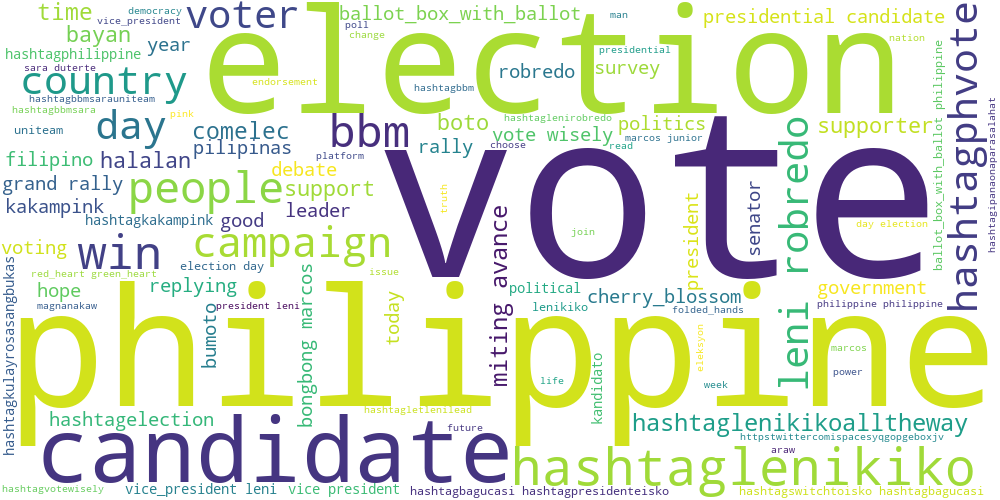

In [145]:
# The use of wordcloud to check if all steps were done correctly
long_string = ','.join(list(dataset['Corrected_Words'].values))
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue', width=1000, height=500)
wordcloud.generate(long_string)
wordcloud.to_image()

## Topic Modeling

In [146]:
import gensim
from gensim import corpora
import numpy as np

documents = dataset['Corrected_Words'].values
tokenized_documents = [doc.split(",") for doc in documents] 

#Create Dictionary
id2word = corpora.Dictionary(tokenized_documents)

#Create Corpus
texts = tokenized_documents

#Term Document Frequency
corpus = [id2word.doc2bow(doc) for doc in tokenized_documents] 

In [147]:
# Build the LDA model
num_topics = 4 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=15,
                                            random_state=42,chunksize=50,per_word_topics=True)
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.017*" hashtagbagucasi" + 0.017*" hashtagpresidenteisko" + 0.016*" hashtagswitchtoisko" + 0.016*" truth" + 0.014*" blue_heart" + 0.009*" news" + 0.008*"vote" + 0.008*" abscbn" + 0.006*" good" + 0.006*" hashtagphvote"
Topic 1: 0.013*" red_heart" + 0.011*" comelec" + 0.010*" green_heart" + 0.010*" trend" + 0.008*" victory_hand" + 0.008*" lie" + 0.008*" leader" + 0.007*" platform" + 0.007*" national" + 0.006*" candidate"
Topic 2: 0.035*" cherry_blossom" + 0.019*" kasalanan" + 0.016*" hashtaglenikiko" + 0.014*" hashtagipanaonaparasalahat" + 0.013*" ballot" + 0.012*" hashtagkulayrosasangbukas" + 0.009*" hashtaglenikikoalltheway" + 0.008*" partylist" + 0.007*" philippine" + 0.007*" tao"
Topic 3: 0.032*" election" + 0.025*" philippine" + 0.020*" vote" + 0.013*" day" + 0.012*" candidate" + 0.010*"replying" + 0.009*" survey" + 0.008*" running" + 0.008*" president" + 0.008*"election"


In [148]:
document_topics = []
for doc_bow in corpus:
    topics = lda_model[doc_bow]
    document_topics.append(topics)

print(f"Topics for Pre-Election Tweets: {document_topics[0]}")

Topics for Pre-Election Tweets: ([(0, 0.028046327), (1, 0.17826411), (2, 0.57694656), (3, 0.216743)], [(0, [3, 2, 1]), (1, [3, 1]), (2, [2, 1, 3]), (3, [2]), (4, [2]), (5, [2]), (6, [2]), (7, [1, 2])], [(0, [(1, 0.010982037), (2, 0.03914677), (3, 0.94406724)]), (1, [(1, 0.29271224), (3, 0.7068602)]), (2, [(1, 0.05725101), (2, 0.88058394), (3, 0.03532818)]), (3, [(2, 0.9988919)]), (4, [(2, 0.9929238)]), (5, [(2, 0.9974492)]), (6, [(2, 0.9984039)]), (7, [(1, 0.98015606), (2, 0.014900274)])])


### Coherence Score

In [149]:

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4471225053450164


### Finding the Optimal Number of Topics

In [150]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, random_state=100,
        #                                         chunksize=200, passes=15, 
        #                                         per_word_topics=True, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=15,
                                            random_state=42,chunksize=50,per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [151]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=8, step=1)

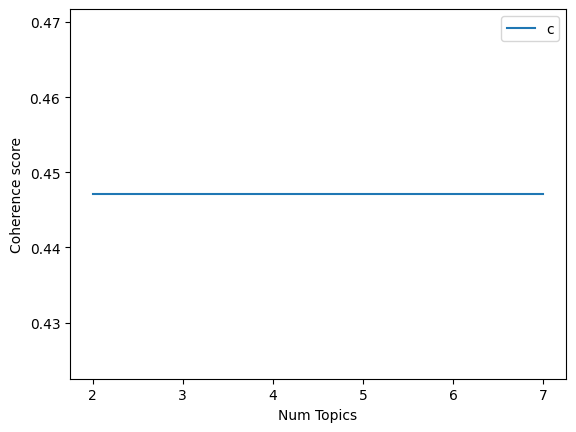

In [152]:
limit=8
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"),loc='best')
plt.show()

In [153]:
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, "has Coherence Value of", round(cv,4))

Number of Topics = 2 has Coherence Value of 0.4471
Number of Topics = 3 has Coherence Value of 0.4471
Number of Topics = 4 has Coherence Value of 0.4471
Number of Topics = 5 has Coherence Value of 0.4471
Number of Topics = 6 has Coherence Value of 0.4471
Number of Topics = 7 has Coherence Value of 0.4471


### Topic Modeling Visualization

In [154]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(background_color='white', width=2500, height=2800, max_words=20,
                         colormap='tab10', color_func=lambda * args, **kwargs: cols[i],
                         prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
topics

[(0,
  [(' hashtagbagucasi', 0.01735724),
   (' hashtagpresidenteisko', 0.017143406),
   (' hashtagswitchtoisko', 0.016462242),
   (' truth', 0.015833344),
   (' blue_heart', 0.014372769),
   (' news', 0.009402337),
   ('vote', 0.008283289),
   (' abscbn', 0.008186704),
   (' good', 0.0061768224),
   (' hashtagphvote', 0.0059072785)]),
 (1,
  [(' red_heart', 0.012594946),
   (' comelec', 0.011277814),
   (' green_heart', 0.010369952),
   (' trend', 0.010157856),
   (' victory_hand', 0.008262201),
   (' lie', 0.008071376),
   (' leader', 0.00784101),
   (' platform', 0.007428133),
   (' national', 0.007166744),
   (' candidate', 0.0063565797)]),
 (2,
  [(' cherry_blossom', 0.03508764),
   (' kasalanan', 0.01886359),
   (' hashtaglenikiko', 0.016230242),
   (' hashtagipanaonaparasalahat', 0.01401296),
   (' ballot', 0.012661509),
   (' hashtagkulayrosasangbukas', 0.011623902),
   (' hashtaglenikikoalltheway', 0.0091317445),
   (' partylist', 0.00834476),
   (' philippine', 0.0072142472),

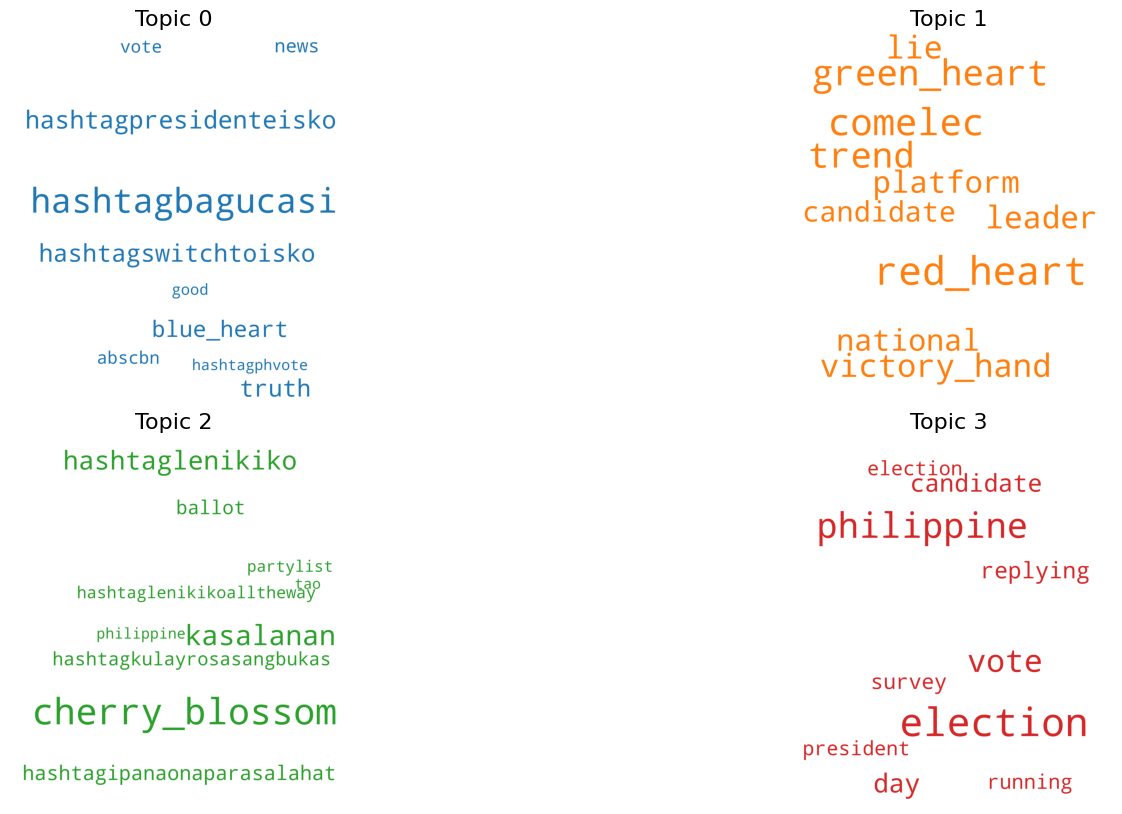

In [155]:
fig, axes = plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words,max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic '+ str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0.1)
plt.axis('off')
plt.margins(x=0,y=0)
plt.tight_layout
plt.show()
